# Predicting Home Prices in Bangalore

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20,10)

## Loading Data

In [2]:
df1 = pd.read_csv("bangalore_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

This shows the number of rows and columns in our data

A count of data samples in each of the area type category is printed below

In [4]:
df1.groupby('area_type')["area_type"].agg("count")

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Here we are going to assume that 'area_type', 'society', 'balcony', and 'availability' are not important in deciding the final price

In [5]:
df2 = df1.drop(['area_type','society','balcony','availability'], axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


The data cleaning process starts now.

## Data Cleaning

In [6]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

Since our data has 13320 rows we can safely drop the rows with NA values

In [7]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [8]:
df3.shape

(13246, 5)

Now we are going to explore the 'size' feature

## Feature Engineering

In [9]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

You can observe that BHK and Bedroom are essentially the same.
To take into account this sort of problems with the dataset I will create a new column called 'bhk' based on the 'size' column

Here we take the string and we tokenize it using the space and take the first token, and that will be the bhk value.

To do that we can use python lambda function. Here the x of lambda contains the column value for each of the rows one by one and on those values you want to apply some transformation. 

Lets say x = '2 BHK'.First we split a string using a space. This gives you two tokens, out of which you want to take the first token which is [0] and but you get a string through this, which should be converted to an integer.

In [10]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

C:\Users\NP\AppData\Local\Temp\ipykernel_13988\2222900254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [11]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [12]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [13]:
df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


The second result looks like an error as the total_sqft number is less. Now lets explore the feature 'total_sqft'

In [14]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

Here you can see values such as '1133 - 1383' which are ranges. So we need to convert these values into single values

First lets see what kind of variations we have. Here we can detect if a given value in 'total_sqft' is a float or not.

First we'll define a function named is_float. How this function works is that we'll try to convert a value in 'total_sqft' to float. If it is not a valid value such as a range, it will throw the exception and there it will return False. Otherwise, it will return True

In [15]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [16]:
df3[~df3['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135,2


In [17]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


We are going to ignore the values that are in other units. And when there are ranges we are going to take the average of those

We are going to write a function that takes in the range as an input and then returns the average value

In [18]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [19]:
convert_sqft_to_num('2166')

2166.0

In [20]:
convert_sqft_to_num('2100 - 2850')

2475.0

In [21]:
convert_sqft_to_num('2100-2850')

2475.0

In [22]:
convert_sqft_to_num('34.46Sq. Meter')

We'll apply the above function onto my 'total_sqft' column and create a new dataframe. 

In [23]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


For apply you can write a lambda function or you can write a native Python function

In [24]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

You can see that the value for 'total_sqft' has changed from a range to a float value

In [25]:
(2100 + 2850) / 2

2475.0

## Feature Engineering

In real estate market the price per square feet is really important. This feature will help us do some outliar cleaning and detection in the later stage

So we are going to create a new feature

In [26]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


Now let us examine the location column. This is a catergorical feature so if there are lot of locations it is going to be a problem.

In [27]:
df5.location.unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

Above, you can see the unique number of locations.
You can see the count below

In [28]:
len(df5.location.unique())

1304

Usually to handle text data we convert it into dummy columns using one hot encoding. If we keep all the locations what happens is we are going to have around 1300 columns in our dataframe which gives us too many features. This is known as the dimensionality curse

One techinique which is available to reduce the dimensions is to come up with the 'other' category. This means when there are around 1300 locations there will be locations which will have only around 1 or 2 data points.

Lets find out how many datapoints are available for our locations.

In [29]:
# This will remove the leading and trailing whitespaces in the locations
df5.location = df5.location.apply(lambda x: x.strip())

location_stats = df5.groupby('location')['location'].agg('count')
location_stats

location
1 Annasandrapalya                                  1
1 Giri Nagar                                       1
1 Immadihalli                                      1
1 Ramamurthy Nagar                                 1
12th cross srinivas nagar banshankari 3rd stage    1
                                                  ..
t.c palya                                          1
tc.palya                                           4
vinayakanagar                                      1
white field,kadugodi                               1
whitefiled                                         1
Name: location, Length: 1293, dtype: int64

Now lets arrange them in the descending order

In [30]:
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

## Dimensionality Reduction

You can see that there are many locations that has only one datapoint. We can come up with some threshold and say that any location which has less than, lets say 10 datapoints is called 'other' location.

First lets know the number of locations that have less than 10 datapoints

In [31]:
len(location_stats[location_stats<=10])

1052

In [32]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

Lets qualify those locations as other locations

 Lets print the total number of unique locations in the dataframe df5

In [33]:
len(df5.location.unique())

1293

We are going to apply a transformation to this dataframe

In [34]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

242

In [35]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outlier detection and outlier removal

We can use different techniques to identify outliars and remove them. You can use standard deviation or even maybe simple domain knowledge 

We can first remove any data rows where the square foot per bedroom is less than some threshold (Lets say less than You can know this threshold value from a domain expert. 

In [36]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [37]:
df5.shape

(13246, 7)

In [38]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12502, 7)

Now lets check the price per square foot

In [39]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Lets write a function that removes the extreme cases based on standard deviation. This function removes price per square feet outliers per location. 

We are going to filter out anything which is beyond 1 standard deviation (We assume that our dataset has a normal distribution)

In [41]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df7 = remove_pps_outliers(df6)
df7.shape

(10241, 7)

You can see that many outliers are removed from the dataset

We assume that the prices of 3bhk should be higher than the prices of 2bhk houses in the same location, and for same square foor area. So we will remove the outliers

We are going to write a function which will give this visualization using a scatterplot. It takes the dataframe and location as the input. It draws a scatterplot on which it will plot 2bhk and 3bhk houses.

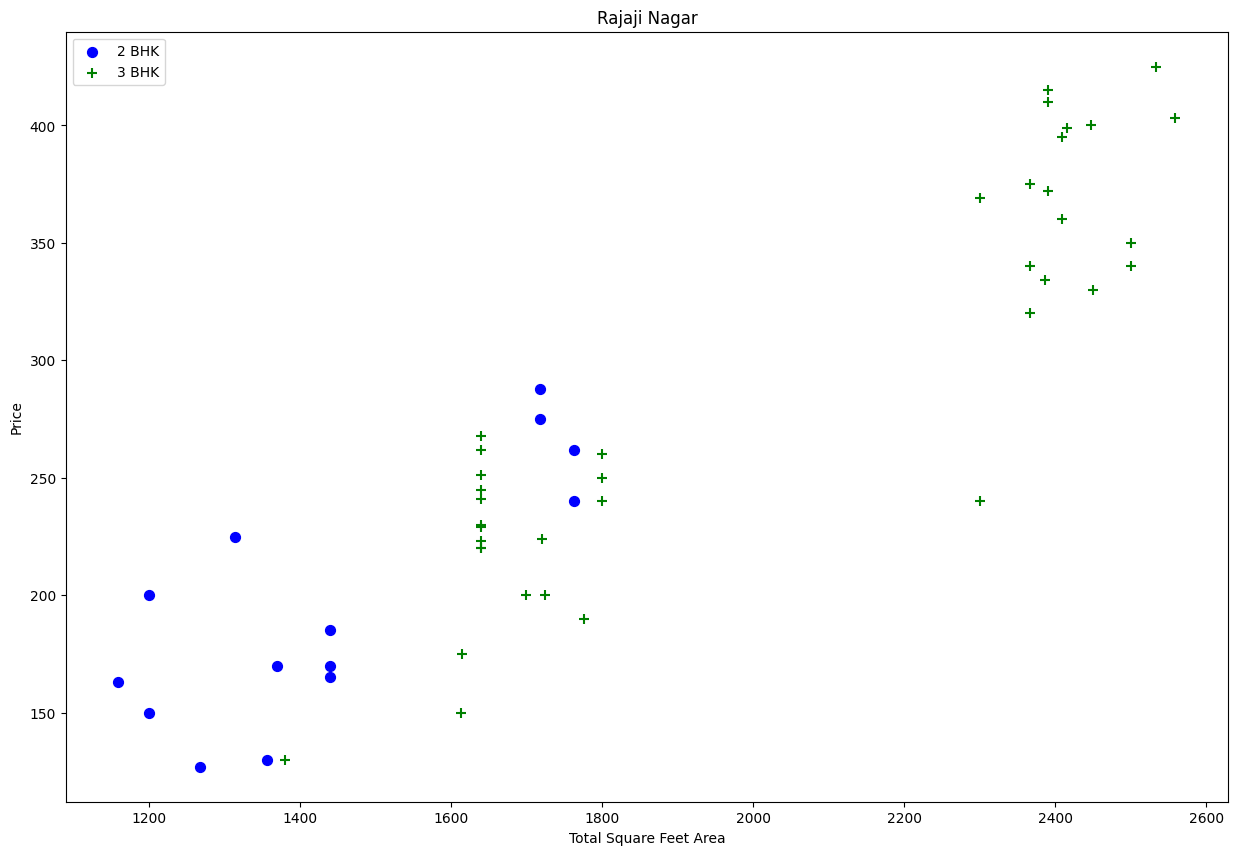

In [45]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()  

plot_scatter_chart(df7, "Rajaji Nagar")

What you find here is that for the same squarefoot areas (for example 1700) the 2bhk prices are higher than the prices of 3bhk. So you have to remove those outliers.

Let us also run this function for a different location and see

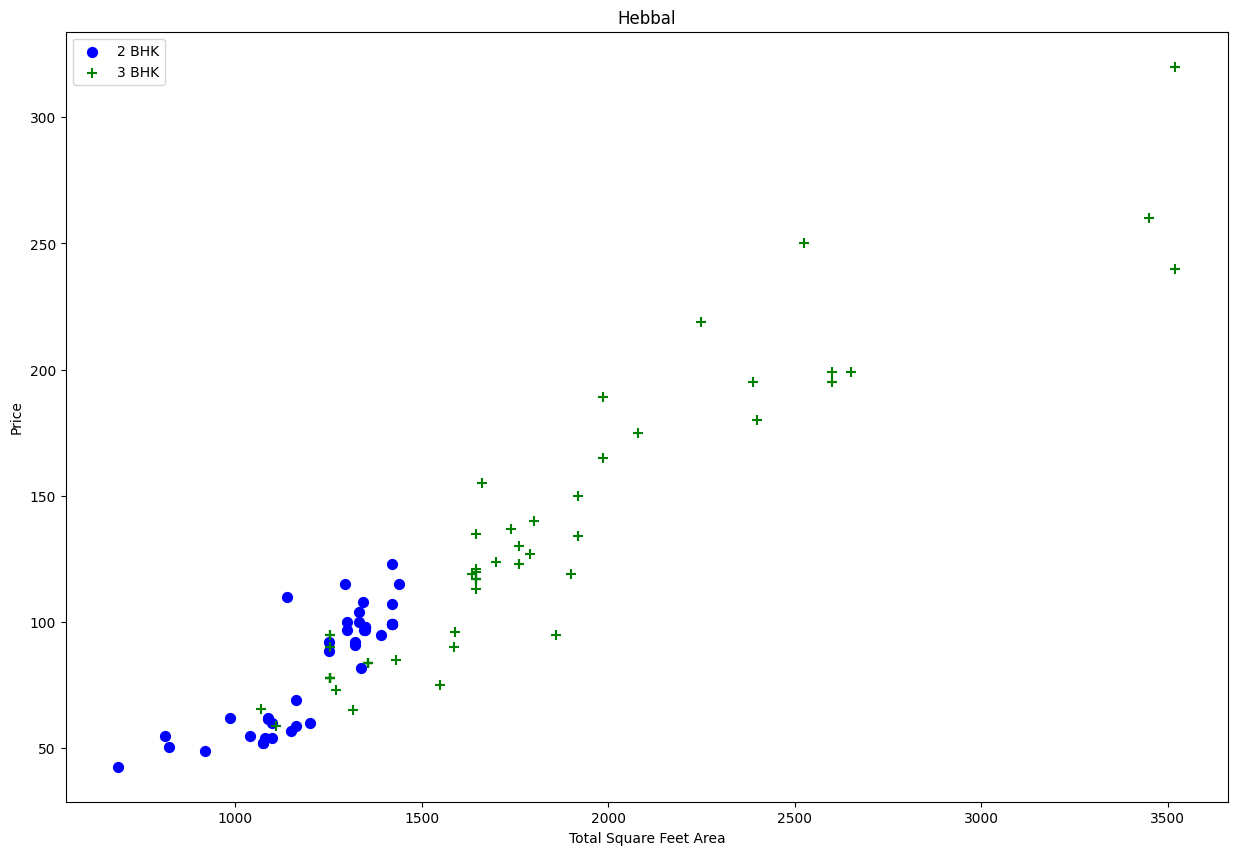

In [46]:
plot_scatter_chart(df7, "Hebbal")

Here are also blue datapoints having higher values than green

We have written a function to remove the outliers. This will create some statistics for 2bhk and 3bhk homes. 
First we are going to create a dictionary with different room numbers and statistics.

Then we will filter out the 2 bhk homes whose mean is less than the mean of the 1bhk houses. 

{    

    '1' : {
        'mean': 4200,
        'std' : 2000,
        'count' : 34
    },
    '2' : {
        'mean' : 4300,
        'std' : 2300,
        'count' : 22
    },
}

In [49]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std' : np.std(bhk_df.price_per_sqft),
                'count' :bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df8 = remove_bhk_outliers(df7)
df8.shape

(7329, 7)

Now let us plot the same scatter plot for the location "Hebbal"

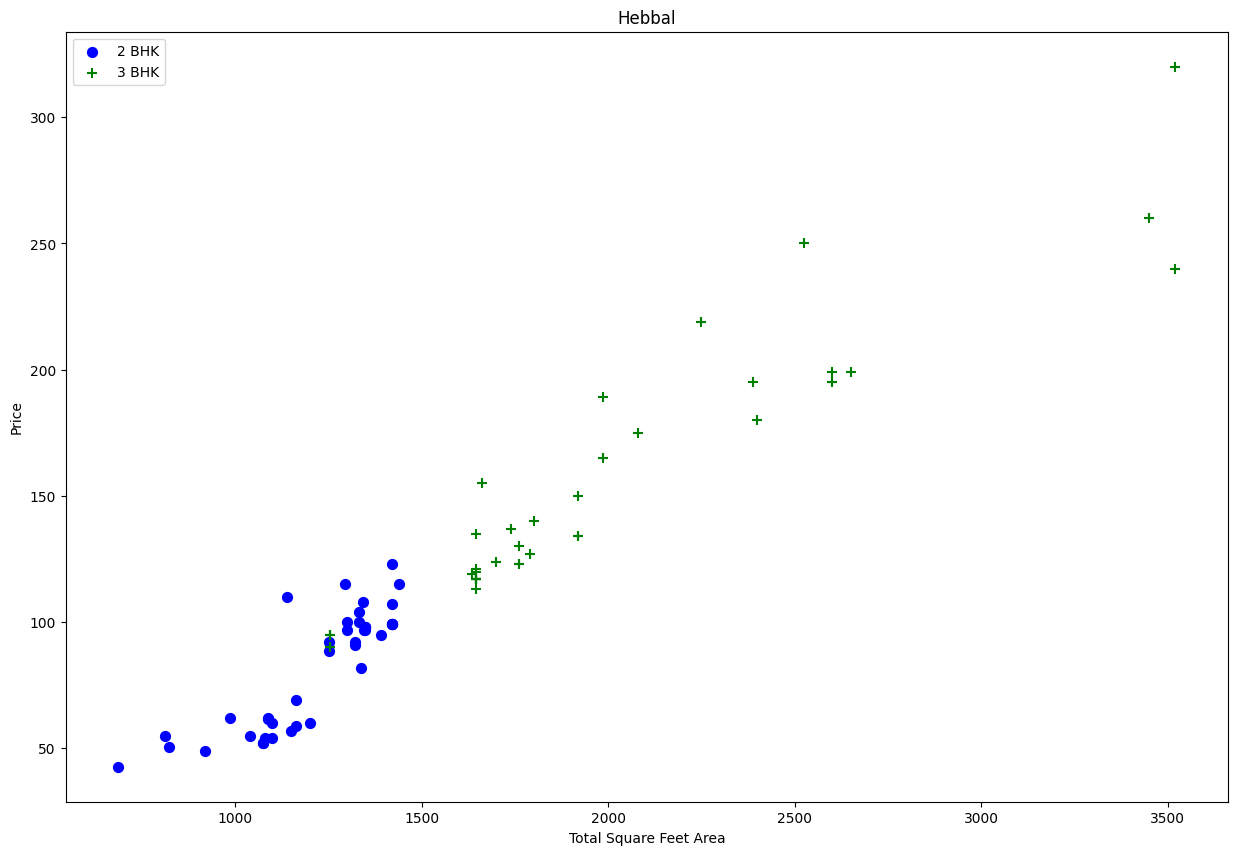

In [52]:
plot_scatter_chart(df8, 'Hebbal')

Now you can notice that all the green datapoints that you had below the blue datapoints are removed. So now, for a specific square feet area the price for a 3bhk is higher than the price for a 2bhk

Now let us plot a histogram to see the number of houses you have per square foot area

Text(0, 0.5, 'Count')

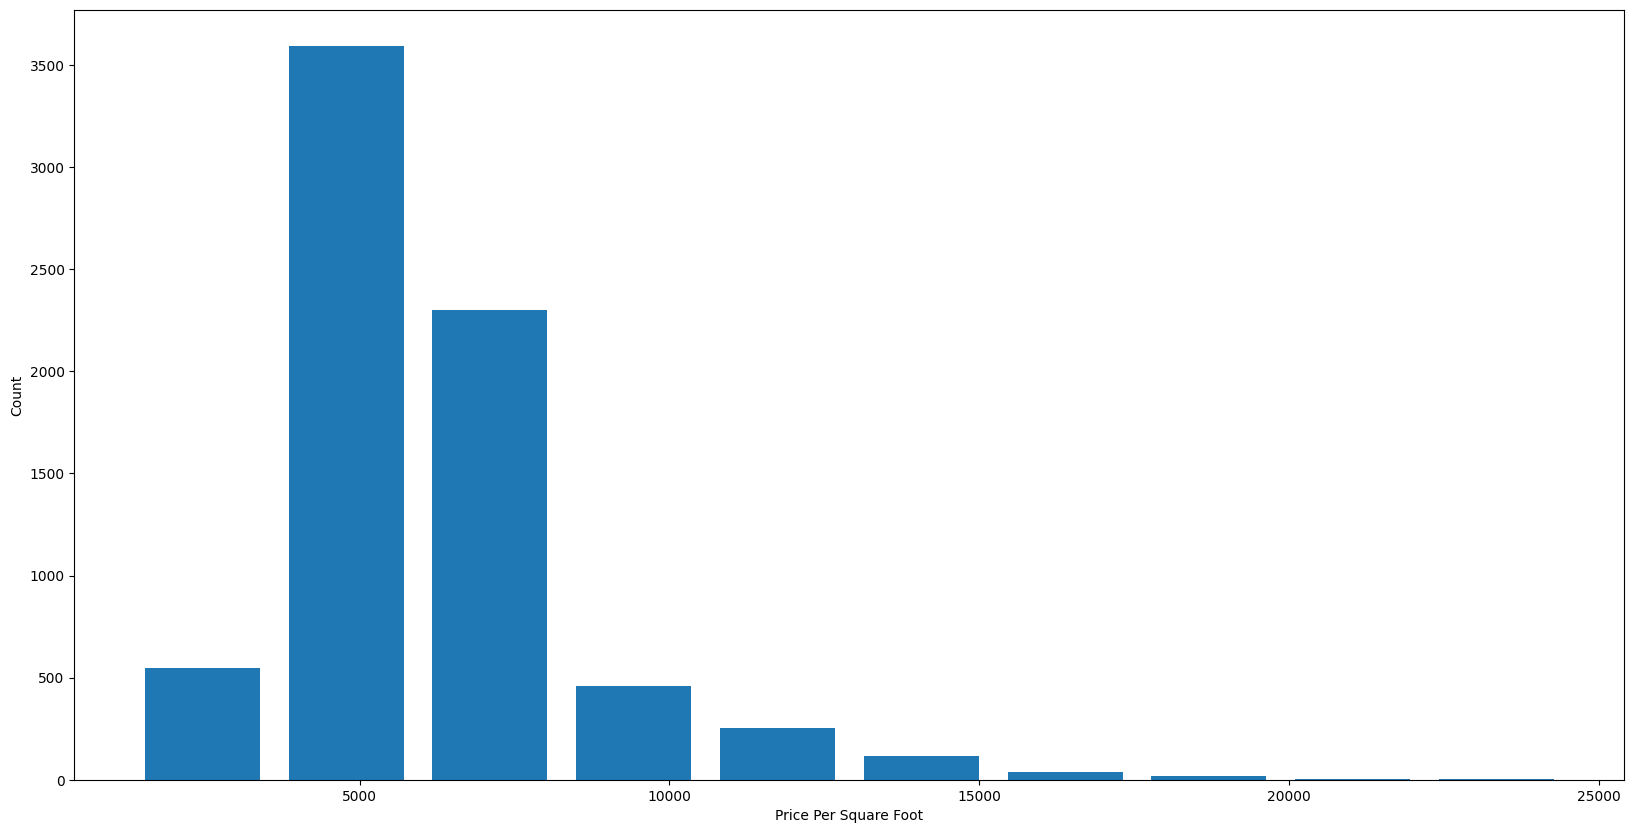

In [53]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Foot")
plt.ylabel("Count")

You can see that you have a majority of datapoints between the range of 0 to 10000 rupees per square foot.

You can see that this has a shape similar to a normal distribution

Now let us explore the 'bathroom' feature

In [54]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [55]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


You can again meet a domain expert and know about a criteria that you can remove the bathroom specific outliers.

Anytime you have the number of bathrooms greater than the number of bedroom,hall, kitchen it is unusual. Lets say the number of bedrooms are 2 and you have 4 bathroom it is quiet unusual.

So we are going to remove as an outlier if the number of bathrooms is greater than the bedrooms + 2.

Text(0, 0.5, 'Count')

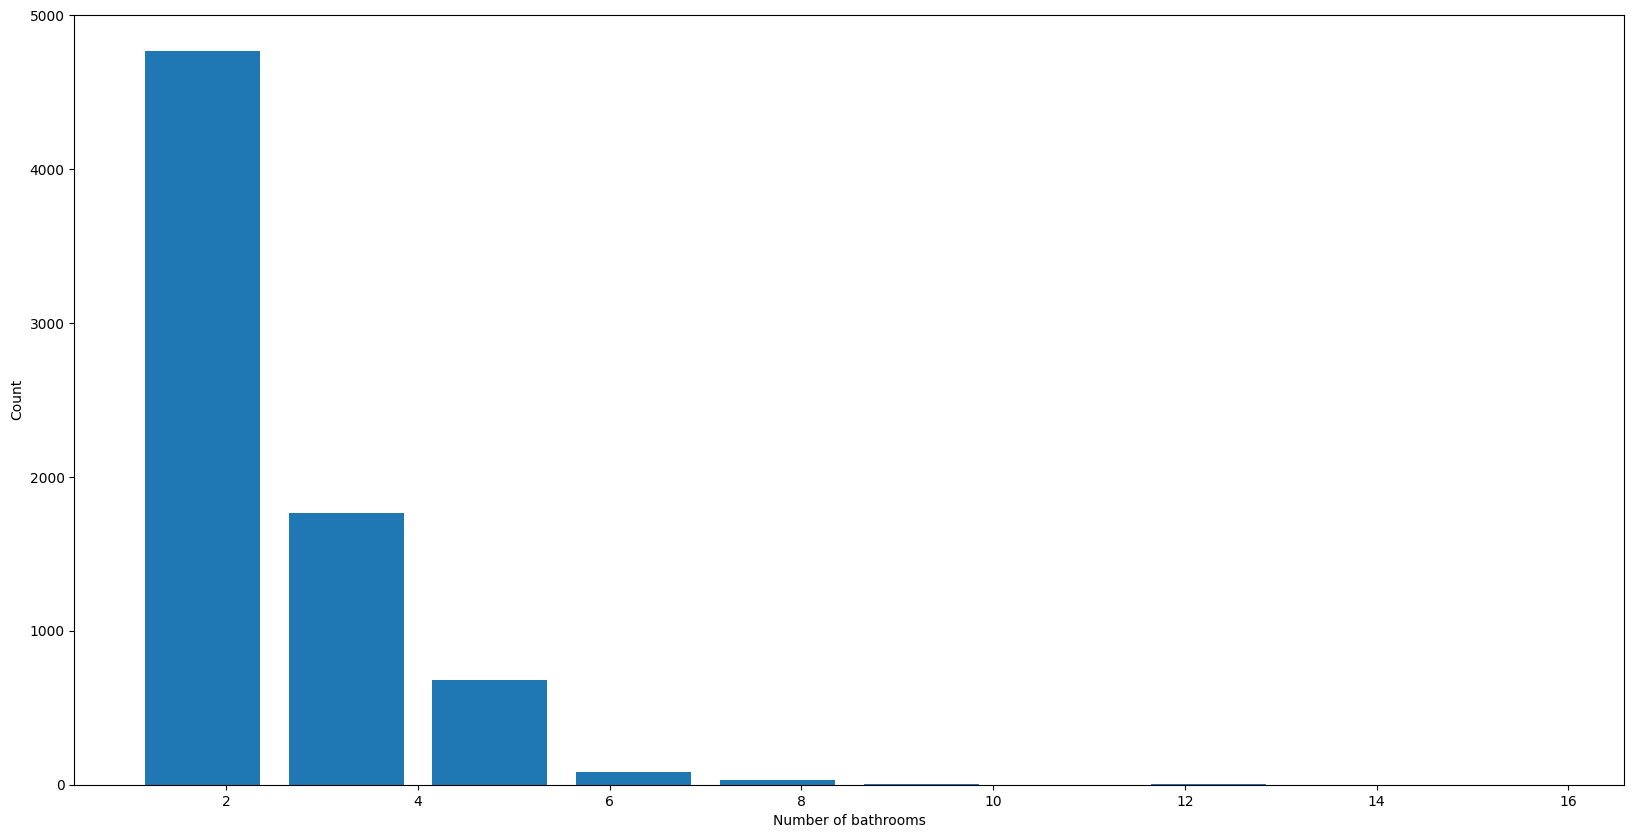

In [56]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

You can observe that most of the properties are having 2 bathrooms.

In [57]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


All of theses are outliers that I can safely remove

In [59]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7251, 7)

Now the dataframe looks pretty much neat and clean so now I can start preparing it for machine learning training. For that I have to drop some unnecessary features such as 'size' and 'price_per_sqft'
(We have 'bhk' instead of 'size' and 'price_per_sqft' was used for outlier detection.

In [60]:
df10 = df9.drop(['size', 'price_per_sqft'], axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
